In [1]:
import numpy as np  
import math
from enum import Enum
from collections import namedtuple

# matplotlib
# ライブラリーのインポート
import matplotlib.pyplot as plt
# インライン表示
%matplotlib inline
# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties

# 家電機器

## 14.　アイロン（ver自立P4）

### 14.1　定義

#### 14.1.1　機器の電源接続状態および動作状態

アイロンの電源接続状態および動作状態は、以下を想定する。

* 電源接続状態：
    * 使用時にのみAC電源に接続される。
    * 非使用時には電源から切断される。  
* 動作状態：
    * 使用時には稼働状態のみが発生する。
    * 非使用時には停止状態となる。  

#### 14.1.2　機器の機能等

アイロンが有する機能は、以下を想定する。  

* 機能：
    * アイロン：主機能である。稼働時に作動する。

想定する状態および機能に対応する添え字は以下のとおりである。なお、単機能であるため、機能に対応する添え字は省略する。  

| 添え字 | 電源接続状態 | 動作状態 |　機能　 | 
|:-----: |:-----------: |:-------: |:------: |    
|ac,opg  |AC電源接続    |稼働      |アイロン |  

### 14.2　消費電力量

日付$d$の時刻$t$におけるアイロンのAC電源接続時の消費電力量$E_{E,Iron,ac,d,t}$は、式(1)により表される。

* AC電源接続時：  
$$ 
\begin{equation*}
    E_{E,Iron,ac,d,t} = E_{E,ac,opg,d,t} 
\end{equation*}
$$


<div style="text-align: right;"> (1) </div>

ここで、  

$E_{E,Iron,ac,d,t}$：日付$d$の時刻$t$におけるAC電源接続時の単位時間当たりの消費電力量[Wh]  
$E_{E,ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時の単位時間当たりの消費電力量[Wh]  

である。

In [2]:
def EE_ac (EE_ac_opg):
    """AC電源接続時の消費電力量[Wh]を計算する""" 
    # EE_ac_opg：AC電源接続下での稼働時の消費電力量[Wh]
    
    return EE_ac_opg

### 14.3　稼働時の消費電力量

日付$d$の時刻$t$におけるAC電源接続下での稼働時の消費電力量は、式(2)により計算される。

* AC電源接続下での稼働時の消費電力量：  
$$ 
\begin{equation*}
    E_{E,ac,opg,d,t} = P_{opg} \times dt_{ac,opg,d,t} \div 3600
\end{equation*}
$$


<div style="text-align: right;"> (2) </div>

ただし、式(3)を満たす。
$$ 
\begin{equation*}
    dt_{ac,opg,d,t} \leq dt_{calc}
\end{equation*}
$$
<div style="text-align: right;"> (3) </div>

ここで、  

$dt_{calc}$：単位時間[s]   
$dt_{ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時間の合計[s]  
$E_{E,ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時の単位時間当たりの消費電力量[Wh]   
$P_{opg}$：1時間当たりの稼働時の平均消費電力[W] 

である。

In [3]:
def EE_ac_opg (dt_ac_opg, P_ac_opg):
    """AC電源接続下での稼働時の消費電力量[Wh]を計算する""" 
    # dt_ac_opg：稼働時間の合計[s]
    # P_ac_opg：稼働時の消費電力[W]
    
    return dt_ac_opg * P_ac_opg / 3600

In [4]:
def check_duration (dt):
    """合計が単位時間を超過しないか否かを確認する"""
    # dt：稼働時間の合計[s](list型))
    
    # dt_calc：単位時間[s]
    dt_calc = 3600.
    
    # 継続時間を積算する
    dt_sum = sum(dt)
    
    # エラーチェック
    if dt_calc < dt_sum:
        # 単位時間を超える場合 => エラー
        try:
            raise ValueError("Error: dt_calc < sum(dt)")
        except ValueError as e:
            print(e)
    else:
        pass

日付$d$の時刻$t$における稼働時の消費電力は、式(4)により計算される。

* 稼働時の消費電力： 
$$ 
\begin{equation*}
    P_{opg} = 0.53 \times P_{rtd,opg} 
\end{equation*}
$$


<div style="text-align: right;"> (4) </div>

ここで、   

$P_{opg}$：1時間当たりの稼働時の平均消費電力[W]  
$P_{rtd,opg}$：定格消費電力[W]  

である。

In [5]:
def P_opg (Prtd_opg):
    """稼働時の消費電力[W]を計算する""" 
    # Prtd_opg：稼働時の消費電力[W]
    
    return 0.53 * Prtd_opg

### 14.4　標準条件

#### 14.4.1　機器仕様

4人世帯の標準的な機器仕様として、下表の設定を用いることができる。

| 番号 | 稼働時の定格消費電力[W] |            備考             |
|:---: | :---------------------: | :-------------------------: |
|  00  | 1400       　　　　     | 4人標準世帯のデフォルト設定 |

In [6]:
# 機器仕様
Spec = {'Iron00':{'Prtd_opg':1400}}  # 稼働時の定格消費電力量[W]

#### 14.4.2　機器使用スケジュール

4人世帯の標準的なスケジュールとして、下表の設定を用いることができる。

| 番号 | スケジュール名称 | 備考 |
|:---: | :--------------: | :--: |
|  00  | 4人標準世帯      | -    |

* 平日：  

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

* 休日在宅： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 

* 休日外出： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

In [7]:
# 機器使用スケジュール：4人標準世帯_AC接続下での稼働時間[s]
Schedule = {
    '4p_standard' : {
        'AC_opg':{'Weekdays'    : [0]* 9 + [360]*1 + [0]*14,  
                  'Holidays_st' : [0]*16 + [360]*1 + [0]* 7, 
                  'Holidays_go' : [0]*24
        } 
    }
}

In [8]:
def plot_hourly_bar_chart(fig_title, y_value_sets, schedule_names, app_status_types, time_use_types,
                          y_label, y_lower, y_upper, y_interval, y_convert_unit):
    '''横軸が時刻（1時間間隔、0～23時間）の棒グラフを作成する'''
    # fig_title：図のタイトル
    # y_value_sets：y軸の値
    # schedule_names：スケジュール名（dictionary型）
    # app_status_types：動作状態のタイプ（dictionary型）
    # time_use_types：生活時間タイプ（dictionary型）
    # y_label：y軸のラベル
    # y_lower：y軸の表示の下限
    # y_ upper：y軸の表示の上限
    # y_ interval：y軸の目盛間隔
    # y_convert_unit：y軸の単位換算係数

    # 日本語フォント
    fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)
    
    # 既存スタイルの使用
    plt.style.use('seaborn-whitegrid')

    # サブプロットの作成
    plt.figure(figsize=(12, 3), dpi=80)
    
    # サブプロットのタイトル
    plt.suptitle(fig_title, fontdict={'fontproperties':fp}, fontsize=14)

    # スケジュール名
    schedule_name = list(schedule_names)[0]
    
    for i, time_use_type in enumerate(list(time_use_types)):
        for j, app_status_type in enumerate(list(app_status_types)):
            # サブプロットの指定
            ax = plt.subplot2grid((1, len(time_use_types)), (0, i))    
            
            # 棒グラフの作成
            # x軸の値
            x_value = np.array([k for k in range(24)])
            # y軸の値（24時間×3スケジュール×動作状態）
            y_value_sets_schedule = y_value_sets[schedule_name]
            # y軸の値（24時間×3スケジュール）
            y_value_sets_status = y_value_sets_schedule[app_status_type]
            # y軸の値（24時間->単位変換）
            y_value = np.array(y_value_sets_status[time_use_type]) * y_convert_unit
            # データ系列名
            app_status_type_jp = app_status_types[app_status_type]
            if len(y_value) > 0:
                if j == 0:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp)
                    y_bottom = y_value
                else:
                    ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=app_status_type_jp, bottom=y_bottom)
                
            # グラフのタイル
            schedule_name_jp = schedule_names[schedule_name]
            time_use_type_jp = time_use_types[time_use_type]
            ax.set_title(schedule_name_jp +'(' + time_use_type_jp + ')' , fontdict={'fontproperties':fp})

            # x軸
            # タイトル
            ax.set_xlabel(u'時刻', fontdict={'fontproperties':fp})
            # 目盛りの位置／ラベル／形式
            # 主目盛
            ax.set_xticks(np.arange(0, 25, 3), minor=False)
            ax.set_xticklabels(np.array([k*3 for k in range(8)]+[0]).astype('str'), minor=False, visible=True)
            ax.tick_params(axis='x', which ='major', direction='in', length=3)
            # 補助目盛
            ax.set_xticks(np.arange(0, 25, 1), minor=True)
            ax.set_xticklabels(np.array([k for k in range(24)]+[0]).astype('str'), minor=True, visible=False)
            ax.tick_params(axis='x', which ='minor', direction='in', length=3)
            # 表示の上限・下限
            ax.set_xbound(lower=0, upper=24)

            # y軸
            #タイトル
            ax.set_ylabel(y_label, fontdict={'fontproperties':fp}) 
            # 目盛りの位置／形式
            #ax.set_yticks(np.arange(0, 30, 5))
            ax.set_yticks(np.arange(y_lower, y_upper+y_interval, y_interval))
            ax.tick_params(axis='y', which ='major', direction='in', length=3)
            # 表示の上限・下限
            ax.set_ybound(lower=y_lower, upper=y_upper)

            # グラフの枠
            ax.spines['right'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['bottom'].set_color('black')
            ax.spines['top'].set_color('black')

            # 主目盛りのグリッド
            ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')

    # 凡例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True,  prop=fp)

    # グラフの重なりを解消
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
    
    
    plt.show()

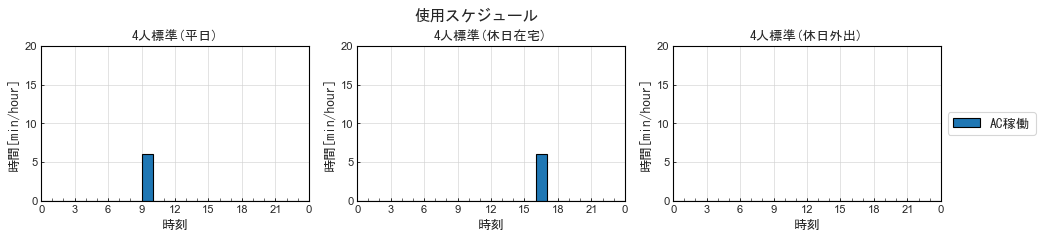

In [9]:
# 機器使用スケジュールの確認
plot_hourly_bar_chart('使用スケジュール', 
                      Schedule, 
                      {'4p_standard':'4人標準'},
                      {'AC_opg':'AC稼働'},
                      {'Weekdays':'平日', 'Holidays_st':'休日在宅', 'Holidays_go':'休日外出'},
                       "時間[min/hour]",  0, 20, 5, 1/60)

### 付録1：サンプルコード

4人標準世帯の標準条件について、サンプルコードを示す。

In [10]:
def get_spec(app_type):
    '''機器仕様を取得する'''
    # app_type：機器タイプ
    
    # 機器仕様の取得
    try:
        spec = Spec[app_type]
    except:
        raise
    
    Prtd_opg = spec['Prtd_opg']
    
    return Prtd_opg

In [11]:
def get_dt(time_use_type, time_of_day, schedule_name):
    """機器使用スケジュールを取得する"""
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23）
    # schedule_name：スケジュール名
     
    # スケジュールの取得
    try:
        schedule_set = Schedule[schedule_name]
    except:
        raise
               
    # 動作状態のタイプ
    app_status_types = list(schedule_set)
    
    # 動作状態ごとの継続時間[s]の取得
    for i, app_status_type in enumerate(app_status_types):
        if app_status_type == 'AC_opg':
            dt_ac_opg = schedule_set[app_status_type][time_use_type][time_of_day]
        else:
            raise

    # 時間超過の確認
    check_duration([dt_ac_opg]) 
    
    return dt_ac_opg

In [12]:
def calc_EE_ac_opg(dt_ac_opg, p_ac_opg):
    """AC電源接続下の稼働時における消費電力量[Wh]を計算する"""
    # dt_ac_opg：AC電源接続時の単位時間における継続時間の合計[s]
    # p_ac_opg：AC電源接続時の消費電力[W]
    
    return EE_ac_opg(dt_ac_opg, p_ac_opg)

In [13]:
def calc_EE_ac(EE_ac_opg):
    """AC電源接続下の稼働時における消費電力量[Wh]を計算する"""
    # EE_ac_opg：AC電源接続下の稼働時における消費電力量[Wh]
    
    return EE_ac(EE_ac_opg)

In [14]:
def calc_EE_Iron_verP4(time_use_type, time_of_day, app_type, schedule_name):
    """アイロンの単位時間当たりの消費電力量を計算する（ver自立P4）"""
    # time_use_type：['Weekdays', 'Holidays_st', 'Holidays_go']
    # time_of_day：時刻（0-23） 
    # app_type：機器タイプ  
    # schedule_name：スケジュール名 
    
    # 機器使用スケジュール[s]を取得
    dt_ac_opg = get_dt(time_use_type, time_of_day, schedule_name)
    
    # 機器仕様を取得
    Prtd_opg = get_spec(app_type)
    
    # AC電源接続下の稼働時における消費電力量[Wh]を計算
    EE_ac_opg = calc_EE_ac_opg(dt_ac_opg, Prtd_opg)
    
    # AC電源接続時における消費電力量[Wh]を計算
    EE_ac = calc_EE_ac (EE_ac_opg)
    
    return EE_ac, EE_ac_opg

4人標準世帯の標準条件に対して、サンプルコードにより平日、休日在宅、休日外出の時刻別消費電力量を計算した結果を示す。

In [15]:
# 消費電力量の計算
calc_ee_ac, calc_ee_ac_opg = np.vectorize(calc_EE_Iron_verP4)([['Weekdays'], ['Holidays_st'], ['Holidays_go']], 
                                                              np.arange(24), 
                                                              'Iron00', 
                                                              '4p_standard')

In [16]:
# 消費電力量の計算結果
calc_EE_Results = {
    '4p_standard' : {
        'AC_opg':{'Weekdays'    : calc_ee_ac_opg[0],  
                  'Holidays_st' : calc_ee_ac_opg[1], 
                  'Holidays_go' : calc_ee_ac_opg[2]
        } 
    }
}

In [17]:
calc_EE_Results

{'4p_standard': {'AC_opg': {'Holidays_go': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
   'Holidays_st': array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.,    0.,  140.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.]),
   'Weekdays': array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           140.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
             0.,    0.,    0.,    0.,    0.,    0.])}}}

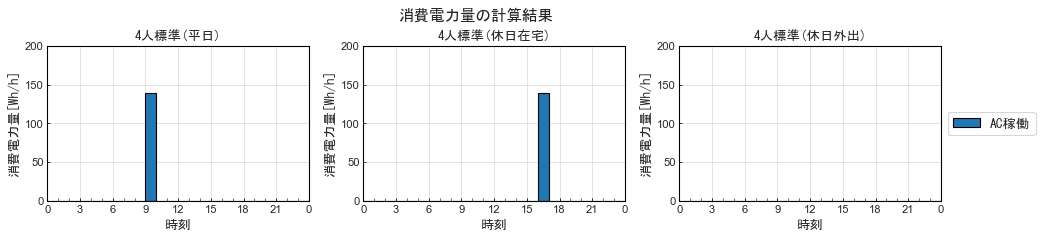

In [18]:
# 消費電力量の計算結果のグラフ
plot_hourly_bar_chart('消費電力量の計算結果', 
                      calc_EE_Results, 
                      {'4p_standard':'4人標準'},
                      {'AC_opg':'AC稼働'},
                      {'Weekdays':'平日', 'Holidays_st':'休日在宅', 'Holidays_go':'休日外出'},
                       "消費電力量[Wh/h]",  0, 200, 50, 1)